# Attention Pooling for Cell Classification

Compare two approaches:
1. **Baseline**: Weighted sum (expression × ProteinBERT) → LogReg
2. **Attention Pooling**: Learned attention (sees embedding + expression) → Classifier

In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
sys.path.insert(0, str(PROJECT_ROOT / "src"))

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import tiledbsoma as soma
import scanpy as sc
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, adjusted_rand_score, silhouette_score
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from umap import UMAP

from model.cell_embeddings import load_gene_embeddings
from model.attention_pooling import AttentionPooling, CellDataset, compute_baseline_embeddings
from preprocess_data.config import OUTPUT_FILES, CENSUS_QUERY_PARAMS

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

/home/jingqiao/FuncCell/.venv/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-11-29 00:08:36.789445: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-29 00:08:36.789538: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-29 00:08:36.790726: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-29 00:08:36.798635: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow bi

Using device: cuda


## 1. Load Gene Embeddings

In [2]:
gene_to_embedding = load_gene_embeddings(OUTPUT_FILES["gene_to_embedding"])
print(f"Loaded {len(gene_to_embedding)} gene embeddings (512-dim)")

Loaded 19294 gene embeddings (512-dim)


## 2. Load Data from Census

In [3]:
N_TRAIN = 10000  # cells per condition for training
N_TEST = 1000    # cells per condition for testing

# Local SOMA database path (for cluster use)
SOMA_URI = "/scratch/sigbio_project_root/sigbio_project25/jingqiao/mccell-single/soma_db_homo_sapiens"

healthy_filter = CENSUS_QUERY_PARAMS["healthy_filter"]
cancer_filter = CENSUS_QUERY_PARAMS["cancer_filter"]
min_genes = CENSUS_QUERY_PARAMS["min_genes"]

print(f"Healthy filter: {healthy_filter}")
print(f"Cancer filter: {cancer_filter}")

Healthy filter: tissue_general == 'breast' and disease == 'normal' and assay == "10x 3' v3" and is_primary_data == True
Cancer filter: tissue_general == 'breast' and disease == 'breast cancer' and assay == "10x 3' v3" and is_primary_data == True


In [4]:
# Query cell IDs from local SOMA
print("Querying cell IDs from local SOMA...")
print(f"Opening: {SOMA_URI}")

experiment = soma.open(SOMA_URI, mode="r")

healthy_obs = experiment.obs.read(
    value_filter=healthy_filter,
    column_names=["soma_joinid"]
).concat().to_pandas()

cancer_obs = experiment.obs.read(
    value_filter=cancer_filter,
    column_names=["soma_joinid"]
).concat().to_pandas()

print(f"Available: {len(healthy_obs)} healthy, {len(cancer_obs)} cancer cells")

# Split into train and test
np.random.seed(42)
healthy_ids = healthy_obs["soma_joinid"].sample(n=N_TRAIN + N_TEST).tolist()
cancer_ids = cancer_obs["soma_joinid"].sample(n=N_TRAIN + N_TEST).tolist()

train_healthy_ids = healthy_ids[:N_TRAIN]
test_healthy_ids = healthy_ids[N_TRAIN:]
train_cancer_ids = cancer_ids[:N_TRAIN]
test_cancer_ids = cancer_ids[N_TRAIN:]

print(f"Train: {len(train_healthy_ids)} healthy + {len(train_cancer_ids)} cancer")
print(f"Test: {len(test_healthy_ids)} healthy + {len(test_cancer_ids)} cancer")

Querying cell IDs from local SOMA...
Opening: /scratch/sigbio_project_root/sigbio_project25/jingqiao/mccell-single/soma_db_homo_sapiens
Available: 1726582 healthy, 34164 cancer cells
Train: 10000 healthy + 10000 cancer
Test: 1000 healthy + 1000 cancer


In [5]:
# Fetch expression data from local SOMA
print("Fetching expression data...")

# Training data - healthy
with experiment.axis_query(
    measurement_name="RNA",
    obs_query=soma.AxisQuery(coords=(train_healthy_ids,)),
) as query:
    train_healthy_adata = query.to_anndata(X_name="raw")

# Training data - cancer
with experiment.axis_query(
    measurement_name="RNA",
    obs_query=soma.AxisQuery(coords=(train_cancer_ids,)),
) as query:
    train_cancer_adata = query.to_anndata(X_name="raw")

# Test data - healthy
with experiment.axis_query(
    measurement_name="RNA",
    obs_query=soma.AxisQuery(coords=(test_healthy_ids,)),
) as query:
    test_healthy_adata = query.to_anndata(X_name="raw")

# Test data - cancer
with experiment.axis_query(
    measurement_name="RNA",
    obs_query=soma.AxisQuery(coords=(test_cancer_ids,)),
) as query:
    test_cancer_adata = query.to_anndata(X_name="raw")

experiment.close()

print(f"Train healthy: {train_healthy_adata.shape}")
print(f"Train cancer: {train_cancer_adata.shape}")
print(f"Test healthy: {test_healthy_adata.shape}")
print(f"Test cancer: {test_cancer_adata.shape}")

Fetching expression data...


/home/jingqiao/FuncCell/.venv/lib64/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jingqiao/FuncCell/.venv/lib64/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jingqiao/FuncCell/.venv/lib64/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jingqiao/FuncCell/.venv/lib64/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jingqiao/FuncCell/.venv/lib64/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitMod

Train healthy: (10000, 61888)
Train cancer: (10000, 61888)
Test healthy: (1000, 61888)
Test cancer: (1000, 61888)


In [6]:
# Apply QC and fix gene names
def preprocess_adata(adata, min_genes=200):
    sc.pp.filter_cells(adata, min_genes=min_genes)
    adata.var_names = adata.var['feature_name'].values
    return adata

train_healthy_adata = preprocess_adata(train_healthy_adata, min_genes)
train_cancer_adata = preprocess_adata(train_cancer_adata, min_genes)
test_healthy_adata = preprocess_adata(test_healthy_adata, min_genes)
test_cancer_adata = preprocess_adata(test_cancer_adata, min_genes)

print(f"After QC:")
print(f"  Train: {train_healthy_adata.n_obs} healthy + {train_cancer_adata.n_obs} cancer")
print(f"  Test: {test_healthy_adata.n_obs} healthy + {test_cancer_adata.n_obs} cancer")

After QC:
  Train: 9999 healthy + 10000 cancer
  Test: 1000 healthy + 1000 cancer


## 3. Define Attention Pooling Model

In [7]:
# Model imported from src/model/attention_pooling.py
print("AttentionPooling model loaded from src/model/attention_pooling.py")
model = AttentionPooling().to(device)
print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")

AttentionPooling model loaded from src/model/attention_pooling.py
Parameters: 197,506


## 4. Create Dataset and DataLoader

In [8]:
# CellDataset imported from src/model/attention_pooling.py
print("CellDataset loaded from src/model/attention_pooling.py")

CellDataset loaded from src/model/attention_pooling.py


In [9]:
# Create datasets
train_labels_healthy = np.zeros(train_healthy_adata.n_obs)
train_labels_cancer = np.ones(train_cancer_adata.n_obs)
test_labels_healthy = np.zeros(test_healthy_adata.n_obs)
test_labels_cancer = np.ones(test_cancer_adata.n_obs)

print("Creating training dataset...")
train_dataset = CellDataset(
    [train_healthy_adata, train_cancer_adata],
    [train_labels_healthy, train_labels_cancer],
    gene_to_embedding
)

print("Creating test dataset...")
test_dataset = CellDataset(
    [test_healthy_adata, test_cancer_adata],
    [test_labels_healthy, test_labels_cancer],
    gene_to_embedding
)

print(f"Train: {len(train_dataset)} cells")
print(f"Test: {len(test_dataset)} cells")

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Creating training dataset...
Using 19122 genes with embeddings


/home/jingqiao/FuncCell/.venv/lib64/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/jingqiao/FuncCell/.venv/lib64/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Creating test dataset...
Using 19122 genes with embeddings
Train: 19999 cells
Test: 2000 cells


## 5. Train Attention Pooling Model

In [10]:
model = AttentionPooling().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCELoss()

n_epochs = 7
train_losses = []

# Get gene embeddings ONCE, move to device (optimization: don't copy 39MB per sample)
gene_embeddings = train_dataset.get_gene_embeddings(device)

print("Training Attention Pooling model...")
print("=" * 50)

for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    
    for batch in train_loader:
        expression = batch['expression'].to(device)
        mask = batch['mask'].to(device)
        labels = batch['label'].to(device)
        
        # Expand gene embeddings to batch size
        batch_size = expression.size(0)
        embeddings = gene_embeddings.unsqueeze(0).expand(batch_size, -1, -1)
        
        pred, _, _ = model(embeddings, expression, mask)
        loss = criterion(pred.squeeze(), labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    
    if epoch % 1 == 0 or epoch == n_epochs - 1:
        print(f"Epoch {epoch:3d}: Loss = {avg_loss:.4f}")

print("=" * 50)
print("Training complete!")

Training Attention Pooling model...
Epoch   0: Loss = 0.1091
Epoch   1: Loss = 0.0518
Epoch   2: Loss = 0.0415
Epoch   3: Loss = 0.0346
Epoch   4: Loss = 0.0334
Epoch   5: Loss = 0.0302
Epoch   6: Loss = 0.0276
Epoch   7: Loss = 0.0256


KeyboardInterrupt: 

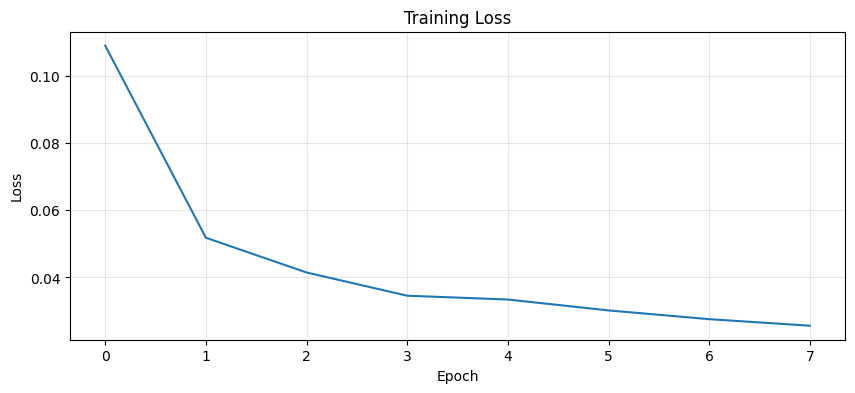

In [11]:
# Plot training loss
plt.figure(figsize=(10, 4))
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True, alpha=0.3)
plt.show()

## 6. Save Model Weights

In [12]:
# Save model weights
weights_dir = PROJECT_ROOT / "models" / "attention_pooling"
weights_dir.mkdir(parents=True, exist_ok=True)

weights_path = weights_dir / "attention_pooling.pt"
torch.save(model.state_dict(), weights_path)
print(f"Model weights saved to: {weights_path}")

Model weights saved to: /home/jingqiao/FuncCell/models/attention_pooling/attention_pooling.pt


## 7. Evaluate on Test Set

In [13]:
def evaluate_model(model, dataloader, dataset, device):
    """Evaluate attention pooling model and return predictions + embeddings."""
    model.eval()
    all_preds = []
    all_probs = []
    all_embeddings = []
    all_labels = []
    
    # Get gene embeddings once
    gene_embeddings = dataset.get_gene_embeddings(device)
    
    with torch.no_grad():
        for batch in dataloader:
            expression = batch['expression'].to(device)
            mask = batch['mask'].to(device)
            labels = batch['label']
            
            # Expand gene embeddings to batch size
            batch_size = expression.size(0)
            embeddings = gene_embeddings.unsqueeze(0).expand(batch_size, -1, -1)
            
            probs, cell_emb, _ = model(embeddings, expression, mask)
            probs = probs.squeeze().cpu().numpy()
            preds = (probs > 0.5).astype(int)
            
            all_probs.extend(probs.tolist() if hasattr(probs, '__iter__') else [probs])
            all_preds.extend(preds.tolist() if hasattr(preds, '__iter__') else [preds])
            all_embeddings.append(cell_emb.cpu().numpy())
            all_labels.extend(labels.numpy().tolist())
    
    return (
        np.array(all_labels),
        np.array(all_preds),
        np.array(all_probs),
        np.vstack(all_embeddings)
    )

# Evaluate attention model
print("Evaluating Attention Pooling on test set...")
attn_labels, attn_preds, attn_probs, attn_embeddings = evaluate_model(model, test_loader, test_dataset, device)
print(f"Test samples: {len(attn_labels)}")

Evaluating Attention Pooling on test set...
Test samples: 2000


## 8. Compute Baseline (Weighted Sum + LogReg)

In [21]:
print("Computing baseline embeddings (weighted sum)...")
train_labels_full, train_baseline_emb_full = compute_baseline_embeddings(train_dataset)
test_labels, test_baseline_emb = compute_baseline_embeddings(test_dataset)

# Subsample training for fair comparison (same as attention)
np.random.seed(42)
subsample_idx = np.random.choice(len(train_labels_full), size=2000, replace=False)
train_labels = train_labels_full[subsample_idx]
train_baseline_emb = train_baseline_emb_full[subsample_idx]

print(f"Train baseline: {train_baseline_emb.shape} (subsampled from {train_baseline_emb_full.shape[0]})")
print(f"Test baseline: {test_baseline_emb.shape}")

# Train LogReg on baseline embeddings
print("\nTraining LogReg on baseline embeddings...")
logreg_baseline = LogisticRegression(max_iter=1000, random_state=42)
logreg_baseline.fit(train_baseline_emb, train_labels)

# Predict baseline
baseline_preds = logreg_baseline.predict(test_baseline_emb)
baseline_probs = logreg_baseline.predict_proba(test_baseline_emb)[:, 1]
print("Baseline evaluation complete.")

# === NEW: Get attention embeddings for LogReg (subsample for speed) ===
print("\nExtracting attention embeddings for LogReg comparison...")

subsample_size = 2000
subsample_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

train_attn_emb = []
train_attn_labels = []
gene_embeddings = train_dataset.get_gene_embeddings(device)

model.eval()
with torch.no_grad():
  count = 0
  for batch in subsample_loader:
      if count >= subsample_size:
          break
      expression = batch['expression'].to(device)
      mask = batch['mask'].to(device)
      labels = batch['label']

      batch_size = expression.size(0)
      embeddings = gene_embeddings.unsqueeze(0).expand(batch_size, -1, -1)

      _, cell_emb, _ = model(embeddings, expression, mask)
      train_attn_emb.append(cell_emb.cpu().numpy())
      train_attn_labels.extend(labels.numpy().tolist())
      count += batch_size

train_attn_emb = np.vstack(train_attn_emb)[:subsample_size]
train_attn_labels = np.array(train_attn_labels)[:subsample_size]
print(f"Extracted {len(train_attn_labels)} training embeddings")

# Train LogReg on attention embeddings
print("Training LogReg on attention embeddings...")
logreg_attn = LogisticRegression(max_iter=1000, random_state=42)
logreg_attn.fit(train_attn_emb, train_attn_labels)

# Predict with LogReg on attention embeddings
attn_logreg_preds = logreg_attn.predict(attn_embeddings)
attn_logreg_probs = logreg_attn.predict_proba(attn_embeddings)[:, 1]
print("Attention + LogReg evaluation complete.")

Computing baseline embeddings (weighted sum)...
Train baseline: (2000, 512) (subsampled from 19999)
Test baseline: (2000, 512)

Training LogReg on baseline embeddings...
Baseline evaluation complete.

Extracting attention embeddings for LogReg comparison...
Extracted 2000 training embeddings
Training LogReg on attention embeddings...
Attention + LogReg evaluation complete.


## 9. Compare Metrics

In [25]:
def get_all_metrics(embeddings, y_true, y_pred, y_probs):
    """Compute classification and clustering metrics."""
    # Classification
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    auc = roc_auc_score(y_true, y_probs)
    
    # Clustering (embedding quality)
    kmeans = KMeans(n_clusters=2, random_state=42, n_init=10).fit(embeddings)
    ari = adjusted_rand_score(y_true, kmeans.labels_)
    asw = silhouette_score(embeddings, y_true)
    
    return {"Accuracy": acc, "Macro F1": f1, "AUC": auc, "ARI": ari, "ASW": asw}

In [26]:
# Compute metrics for both methods
print("=" * 80)
print("COMPARISON: BASELINE vs ATTENTION (Neural) vs ATTENTION (LogReg)")
print("=" * 80)

baseline_metrics = get_all_metrics(test_baseline_emb, test_labels, baseline_preds, baseline_probs)
attention_nn_metrics = get_all_metrics(attn_embeddings, attn_labels, attn_preds, attn_probs)
attention_lr_metrics = get_all_metrics(attn_embeddings, attn_labels, attn_logreg_preds, attn_logreg_probs)

# Create comparison table
print(f"\n{'Metric':<12} {'Baseline+LR':<14} {'Attn+NN':<14} {'Attn+LR':<14} {'LR Diff':<10}")
print("-" * 64)
for metric in baseline_metrics:
  b = baseline_metrics[metric]
  a_nn = attention_nn_metrics[metric]
  a_lr = attention_lr_metrics[metric]
  diff = a_lr - b  # Fair comparison: both use LogReg
  sign = "+" if diff > 0 else ""
  print(f"{metric:<12} {b:<14.3f} {a_nn:<14.3f} {a_lr:<14.3f} {sign}{diff:.3f}")

print("\n* LR Diff = Attn+LR - Baseline+LR (fair comparison, same classifier)")

comparison_df = pd.DataFrame({
  'Metric': list(baseline_metrics.keys()),
  'Baseline+LR': list(baseline_metrics.values()),
  'Attn+NN': list(attention_nn_metrics.values()),
  'Attn+LR': list(attention_lr_metrics.values())
})
comparison_df['LR_Improvement'] = comparison_df['Attn+LR'] - comparison_df['Baseline+LR']
comparison_df.to_csv(PROJECT_ROOT / "data" / "attention_comparison.csv", index=False)
print(f"\nComparison saved to: {PROJECT_ROOT / 'data' / 'attention_comparison.csv'}")

COMPARISON: BASELINE vs ATTENTION (Neural) vs ATTENTION (LogReg)

Metric       Baseline+LR    Attn+NN        Attn+LR        LR Diff   
----------------------------------------------------------------
Accuracy     0.971          0.994          0.995          +0.024
Macro F1     0.970          0.993          0.994          +0.024
AUC          0.994          0.999          0.999          +0.005
ARI          0.854          0.970          0.970          +0.117
ASW          0.629          0.742          0.742          +0.113

* LR Diff = Attn+LR - Baseline+LR (fair comparison, same classifier)

Comparison saved to: /home/jingqiao/FuncCell/data/attention_comparison.csv


## 10. UMAP Visualization (The "Money Shot")

Computing UMAP projections...


/home/jingqiao/FuncCell/.venv/lib64/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/jingqiao/FuncCell/.venv/lib64/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


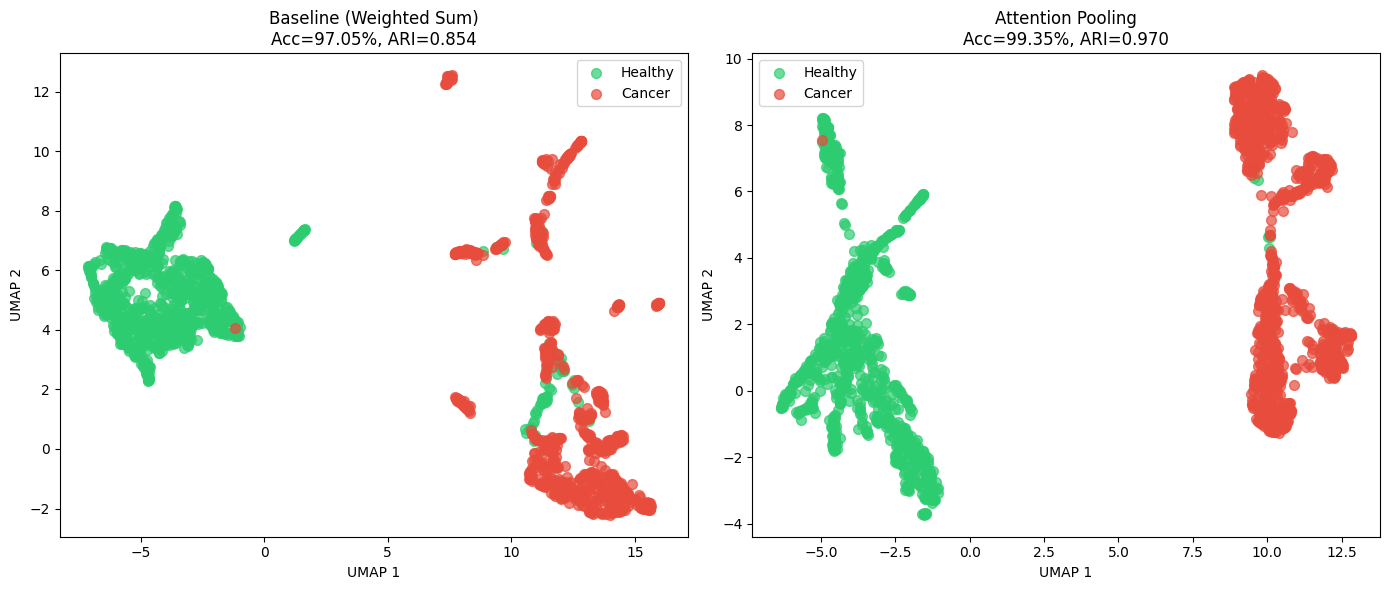

UMAP plot saved to: /home/jingqiao/FuncCell/data/attention_umap_comparison.png


In [24]:
# UMAP for both embedding methods
print("Computing UMAP projections...")

umap_baseline = UMAP(n_neighbors=15, min_dist=0.1, random_state=42).fit_transform(test_baseline_emb)
umap_attention = UMAP(n_neighbors=15, min_dist=0.1, random_state=42).fit_transform(attn_embeddings)

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

colors = ['#2ecc71', '#e74c3c']
labels_names = ['Healthy', 'Cancer']

# Baseline
ax1 = axes[0]
for i, (color, name) in enumerate(zip(colors, labels_names)):
    mask = test_labels == i
    ax1.scatter(umap_baseline[mask, 0], umap_baseline[mask, 1], c=color, label=name, alpha=0.7, s=50)
ax1.set_xlabel('UMAP 1')
ax1.set_ylabel('UMAP 2')
ax1.set_title(f'Baseline (Weighted Sum)\nAcc={baseline_metrics["Accuracy"]:.2%}, ARI={baseline_metrics["ARI"]:.3f}')
ax1.legend()

# Attention
ax2 = axes[1]
for i, (color, name) in enumerate(zip(colors, labels_names)):
    mask = attn_labels == i
    ax2.scatter(umap_attention[mask, 0], umap_attention[mask, 1], c=color, label=name, alpha=0.7, s=50)
ax2.set_xlabel('UMAP 1')
ax2.set_ylabel('UMAP 2')
ax2.set_title(f'Attention Pooling\nAcc={attention_metrics["Accuracy"]:.2%}, ARI={attention_metrics["ARI"]:.3f}')
ax2.legend()

plt.tight_layout()
plt.savefig(PROJECT_ROOT / "data" / "attention_umap_comparison.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"UMAP plot saved to: {PROJECT_ROOT / 'data' / 'attention_umap_comparison.png'}")

## Summary

| Method | Key Idea |
|--------|----------|
| **Baseline** | attention = expression (fixed weights) |
| **Attention Pooling** | attention = f(embedding, expression) (learned) |

The attention model can learn:
- "TP53 matters even when lowly expressed"
- "Ignore housekeeping genes even if highly expressed"